## Run XGBoost Regression Model for Municipality_based dataset

In [1]:
%load_ext jupyter_black

In [2]:
import matplotlib.pyplot as plt
import statsmodels.api as sm
import xgboost as xgb
import pandas as pd
import numpy as np
import statistics
import os

from sklearn.metrics import f1_score, mean_squared_error, mean_absolute_error, max_error
from collections import defaultdict
from xgboost.sklearn import XGBRegressor
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split

/Users/mersedehkooshki/opt/anaconda3/envs/global-storm/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
# Import the CSV file to a dataframe
df = pd.read_csv("data/df_merged_2.csv")

# Remove the duplicated rows
df.drop_duplicates(keep="first", inplace=True)
df = df.reset_index(drop=True)

df

,Mun_Code,typhoon,HAZ_rainfall_Total,HAZ_rainfall_max_6h,HAZ_rainfall_max_24h,HAZ_v_max,HAZ_dis_track_min,GEN_landslide_per,GEN_stormsurge_per,GEN_Bu_p_inSSA,...,VUL_LightRoof_LightWall,VUL_LightRoof_SalvageWall,VUL_SalvagedRoof_StrongWall,VUL_SalvagedRoof_LightWall,VUL_SalvagedRoof_SalvageWall,VUL_vulnerable_groups,VUL_pantawid_pamilya_beneficiary,DAM_perc_dmg,HAZ_v_max_3,y_norm
0,PH175101000,DURIAN2006,185.828571,14.716071,7.381696,55.032241,2.478142,2.64,6.18,6.18,...,41.892832,1.002088,0.000000,0.027836,0.083507,2.951511,46.931106,3.632568,166667.757548,3.34975
1,PH083701000,DURIAN2006,8.818750,0.455208,0.255319,8.728380,288.358553,0.06,0.00,0.00,...,13.645253,0.549120,0.030089,0.090266,0.112833,3.338873,25.989168,0.000000,664.968323,0.00000
2,PH015501000,DURIAN2006,24.175000,2.408333,0.957639,10.945624,274.953818,1.52,1.28,1.28,...,15.592295,0.075838,0.000000,0.015168,0.075838,2.131755,32.185651,0.000000,1311.358762,0.00000
3,PH015502000,DURIAN2006,14.930000,1.650000,0.586250,12.108701,252.828578,0.00,0.00,0.00,...,7.100454,0.023280,0.011640,0.000000,0.128041,1.589369,29.612385,0.000000,1775.385328,0.00000
4,PH175302000,DURIAN2006,13.550000,1.054167,0.528125,10.660943,258.194381,5.52,0.36,0.36,...,30.354796,0.000000,0.000000,0.032852,0.000000,1.387007,35.052562,0.000000,1211.676901,0.00000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7855,PH084823000,NOUL2015,9.700000,0.408333,0.216146,8.136932,277.107823,1.80,6.25,6.25,...,32.492212,0.311526,0.031153,0.155763,0.031153,2.827833,31.308411,0.000000,538.743551,0.00000
7856,PH015547000,NOUL2015,17.587500,1.414583,0.386458,9.818999,305.789817,0.00,0.00,0.00,...,4.703833,0.027875,0.000000,0.034843,0.097561,1.073268,12.766551,0.000000,946.676507,0.00000
7857,PH025014000,NOUL2015,11.487500,0.614583,0.230319,15.791907,210.313249,0.06,0.09,0.09,...,3.063753,0.022528,0.000000,0.067583,0.022528,1.140109,9.348952,0.000000,3938.254316,0.00000
7858,PH140127000,NOUL2015,11.600000,1.400000,0.412766,13.867145,218.189328,0.00,0.00,0.00,...,3.119093,0.000000,0.000000,0.000000,0.000000,2.837537,21.928166,0.000000,2666.620370,0.00000


array([[<AxesSubplot:title={'center':'y_norm'}>]], dtype=object)

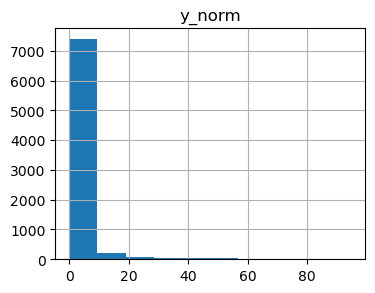

In [4]:
# display(combined_input_data)
df.hist(column="y_norm", figsize=(4, 3))

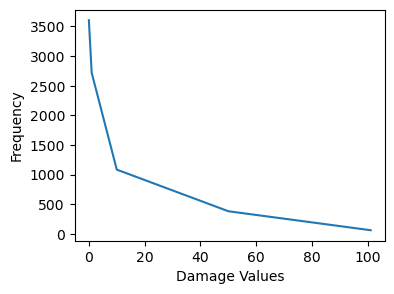

In [5]:
# The Old and New set of bins
bins2 = [0, 0.00009, 1, 10, 50, 101]
plt.figure(figsize=(4, 3))
samples_per_bin2, binsP2 = np.histogram(df["y_norm"], bins=bins2)
plt.xlabel("Damage Values")
plt.ylabel("Frequency")
plt.plot(binsP2[1:], samples_per_bin2)

In [6]:
print(samples_per_bin2)
print(binsP2)

[3605 2721 1086  384   64]
[0.00e+00 9.00e-05 1.00e+00 1.00e+01 5.00e+01 1.01e+02]


In [7]:
df["y_norm"].value_counts(bins=binsP2)

(-0.001, 9e-05]    3605
(9e-05, 1.0]       2721
(1.0, 10.0]        1086
(10.0, 50.0]        384
(50.0, 101.0]        64
Name: y_norm, dtype: int64

In [8]:
bin_index2 = np.digitize(df["y_norm"], bins=binsP2)

In [9]:
y_input_strat = bin_index2

In [10]:
all_features = [
    "HAZ_rainfall_Total",
    "HAZ_rainfall_max_6h",
    "HAZ_rainfall_max_24h",
    "HAZ_v_max",
    "HAZ_v_max_3",
    "HAZ_dis_track_min",
    "GEN_landslide_per",
    "GEN_stormsurge_per",
    #'GEN_Bu_p_inSSA',
    #'GEN_Bu_p_LS',
    "GEN_Red_per_LSbldg",
    "GEN_Or_per_LSblg",
    "GEN_Yel_per_LSSAb",
    "GEN_RED_per_SSAbldg",
    #'GEN_OR_per_SSAbldg',
    "GEN_Yellow_per_LSbl",
    "TOP_mean_slope",
    "TOP_mean_elevation_m",
    "TOP_ruggedness_stdev",
    #'TOP_mean_ruggedness',
    #'TOP_slope_stdev',
    "VUL_poverty_perc",
    "GEN_with_coast",
    "GEN_coast_length",
    "VUL_Housing_Units",
    "VUL_StrongRoof_StrongWall",
    "VUL_StrongRoof_LightWall",
    "VUL_StrongRoof_SalvageWall",
    "VUL_LightRoof_StrongWall",
    "VUL_LightRoof_LightWall",
    "VUL_LightRoof_SalvageWall",
    "VUL_SalvagedRoof_StrongWall",
    "VUL_SalvagedRoof_LightWall",
    "VUL_SalvagedRoof_SalvageWall",
    "VUL_vulnerable_groups",
    "VUL_pantawid_pamilya_beneficiary",
]


glob_features = [  #'HAZ_rainfall_Total',
    "HAZ_rainfall_max_6h",
    "HAZ_rainfall_max_24h",
    "HAZ_v_max",
    #'HAZ_v_max_3',
    "HAZ_dis_track_min",
    #'GEN_landslide_per',
    #'GEN_stormsurge_per',
    #'GEN_Bu_p_inSSA',
    #'GEN_Bu_p_LS',
    #'GEN_Red_per_LSbldg',
    #'GEN_Or_per_LSblg',
    #'GEN_Yel_per_LSSAb',
    #'GEN_RED_per_SSAbldg',
    #'GEN_OR_per_SSAbldg',
    #'GEN_Yellow_per_LSbl',
    "TOP_mean_slope",
    "TOP_mean_elevation_m",
    "TOP_ruggedness_stdev",
    "TOP_mean_ruggedness",
    "TOP_slope_stdev",
    #'VUL_poverty_perc',
    "GEN_with_coast",
    "GEN_coast_length",
    "VUL_Housing_Units",
    #'VUL_StrongRoof_StrongWall',
    #'VUL_StrongRoof_LightWall',
    #'VUL_StrongRoof_SalvageWall',
    #'VUL_LightRoof_StrongWall',
    #'VUL_LightRoof_LightWall',
    #'VUL_LightRoof_SalvageWall',
    #'VUL_SalvagedRoof_StrongWall',
    #'VUL_SalvagedRoof_LightWall',
    #'VUL_SalvagedRoof_SalvageWall',
    #'VUL_vulnerable_groups',
    #'VUL_pantawid_pamilya_beneficiary',
]

In [11]:
# Defin two lists to save total RMSE of test and train data

test_RMSE = defaultdict(list)
train_RMSE = defaultdict(list)

test_AVE = defaultdict(list)

In [12]:
# Ask the user whether to use all features set or global features set
feature_set = int(input("Enter 1 for all features, 2 for global features: "))

Enter 1 for all features, 2 for global features: 1


In [13]:
if feature_set == 1:
    features = all_features
    print(len(features))

elif feature_set == 2:
    features = glob_features
    print(len(features))

else:
    print("Invalid input. Please enter 1 or 2")

31


In [14]:
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

# Split X and y from dataframe features
X = df[features]
display(X.columns)
y = df["y_norm"]

scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

Index(['HAZ_rainfall_Total', 'HAZ_rainfall_max_6h', 'HAZ_rainfall_max_24h',
       'HAZ_v_max', 'HAZ_v_max_3', 'HAZ_dis_track_min', 'GEN_landslide_per',
       'GEN_stormsurge_per', 'GEN_Red_per_LSbldg', 'GEN_Or_per_LSblg',
       'GEN_Yel_per_LSSAb', 'GEN_RED_per_SSAbldg', 'GEN_Yellow_per_LSbl',
       'TOP_mean_slope', 'TOP_mean_elevation_m', 'TOP_ruggedness_stdev',
       'VUL_poverty_perc', 'GEN_with_coast', 'GEN_coast_length',
       'VUL_Housing_Units', 'VUL_StrongRoof_StrongWall',
       'VUL_StrongRoof_LightWall', 'VUL_StrongRoof_SalvageWall',
       'VUL_LightRoof_StrongWall', 'VUL_LightRoof_LightWall',
       'VUL_LightRoof_SalvageWall', 'VUL_SalvagedRoof_StrongWall',
       'VUL_SalvagedRoof_LightWall', 'VUL_SalvagedRoof_SalvageWall',
       'VUL_vulnerable_groups', 'VUL_pantawid_pamilya_beneficiary'],
      dtype='object')

In [15]:
# Run XGBoost Reduced Overfitting in for loop to estimate RMSE per bins

for i in range(20):
    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, df["y_norm"], stratify=y_input_strat, test_size=0.2
    )

    # XGBoost Reduced Overfitting
    xgb = XGBRegressor(
        base_score=0.5,
        booster="gbtree",
        colsample_bylevel=0.8,
        colsample_bynode=0.8,
        colsample_bytree=0.8,
        gamma=3,
        eta=0.01,
        importance_type="gain",
        learning_rate=0.1,
        max_delta_step=0,
        max_depth=4,
        min_child_weight=1,
        missing=1,
        n_estimators=100,
        early_stopping_rounds=10,
        n_jobs=1,
        nthread=None,
        objective="reg:squarederror",
        reg_alpha=0,
        reg_lambda=1,
        scale_pos_weight=1,
        seed=None,
        silent=None,
        subsample=0.8,
        verbosity=1,
        eval_metric=["rmse", "logloss"],
        random_state=0,
    )

    eval_set = [(X_train, y_train)]
    xgb_model = xgb.fit(
        X_train,
        y_train,
        eval_set=eval_set,
        verbose=False,
    )

    X2 = sm.add_constant(X_train)
    est = sm.OLS(y_train, X2)
    est2 = est.fit()
    print(est2.summary())

    X2_test = sm.add_constant(X_test)

    y_pred_train_LREG = est2.predict(X2)
    mse_train_idx_LREG = mean_squared_error(y_train, y_pred_train_LREG)
    rmse_train_LREG = np.sqrt(mse_train_idx_LREG)

    ypred_LREG = est2.predict(X2_test)
    mse_idx_LREG = mean_squared_error(y_test, ypred_LREG)
    rmse_LREG = np.sqrt(mse_idx_LREG)

    print("----- Training ------")
    print(f"LREG Root mean squared error: {rmse_train_LREG:.2f}")
    print("----- Test ------")
    print(f"LREG Root mean squared error: {rmse_LREG:.2f}")

    # Calculate RMSE in total

    y_pred_train = xgb.predict(X_train)

    # Clip the predicted values to be within the range of zero to 100
    y_pred_train_clipped = y_pred_train.clip(0, 100)
    mse_train_idx = mean_squared_error(y_train, y_pred_train_clipped)
    rmse_train = np.sqrt(mse_train_idx)

    y_pred = xgb.predict(X_test)

    # Clip the predicted values to be within the range of zero to 100
    y_pred_clipped = y_pred.clip(0, 100)
    mse_idx = mean_squared_error(y_test, y_pred_clipped)
    rmse = np.sqrt(mse_idx)

    print("----- Training ------")
    print(f"Root mean squared error: {rmse_train:.2f}")

    print("----- Test ------")
    print(f"Root mean squared error: {rmse:.2f}")

    test_RMSE["all"].append(rmse)
    train_RMSE["all"].append(rmse_train)

    # Calculate Average Error in total

    ave = (y_pred_clipped - y_test).sum() / len(y_test)

    print("----- Test ------")
    print(f"Average Error: {ave:.2f}")

    test_AVE["all"].append(ave)

    # Calculate RMSE per bins

    bin_index_test = np.digitize(y_test, bins=binsP2)
    bin_index_train = np.digitize(y_train, bins=binsP2)

    for bin_num in range(1, 6):

        mse_train_idx = mean_squared_error(
            y_train[bin_index_train == bin_num],
            y_pred_train_clipped[bin_index_train == bin_num],
        )
        rmse_train = np.sqrt(mse_train_idx)

        mse_idx = mean_squared_error(
            y_test[bin_index_test == bin_num],
            y_pred_clipped[bin_index_test == bin_num],
        )
        rmse = np.sqrt(mse_idx)

        train_RMSE[bin_num].append(rmse_train)
        test_RMSE[bin_num].append(rmse)

        # Calculate Average Error per bins

        ave = (
            y_pred_clipped[bin_index_test == bin_num]
            - y_test[bin_index_test == bin_num]
        ).sum() / len(y_test[bin_index_test == bin_num])
        test_AVE[bin_num].append(ave)

[12:59:00] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:576: 
Parameters: { "early_stopping_rounds" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


                            OLS Regression Results                            
Dep. Variable:                 y_norm   R-squared:                       0.551
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     247.7
Date:                Wed, 13 Sep 2023   Prob (F-statistic):               0.00
Time:                        12:59:01   Log-Likelihood:                -19512.
No. Observations:                6288   AIC:                         3.909e+04
Df Residua

In [16]:
# Define a function to plot RMSEs
def rmse_bin_plot(te_rmse, tr_rmse, te_ave, min_rg, max_rg, step):

    m_test_rmse = statistics.mean(te_rmse)
    plt.figure(figsize=(4, 3))
    plt.axvline(m_test_rmse, color="b", linestyle="dashed")
    plt.hist(
        te_rmse,
        bins=np.arange(min_rg, max_rg, step),
        edgecolor="k",
        histtype="bar",
        density=True,
    )
    sd_test_rmse = statistics.stdev(te_rmse)

    m_train_rmse = statistics.mean(tr_rmse)
    plt.axvline(m_train_rmse, color="red", linestyle="dashed")
    plt.hist(
        tr_rmse,
        bins=np.arange(min_rg, max_rg, step),
        color="orange",
        edgecolor="k",
        histtype="bar",
        density=True,
        alpha=0.7,
    )
    sd_train_rmse = statistics.stdev(tr_rmse)

    # Average Error
    m_test_ave = statistics.mean(te_ave)
    sd_test_ave = statistics.stdev(te_ave)

    print(f"mean_RMSE_test: {m_test_rmse:.2f}")
    # print(f"mean_RMSE_train: {m_train_rmse:.2f}")

    print(f"stdev_RMSE_test: {sd_test_rmse:.2f}")
    # print(f"stdev_RMSE_train: {sd_train_rmse:.2f}")

    print(f"mean_AVE_test: {m_test_ave:.2f}")

    print(f"stdev_AVE_test: {sd_test_ave:.2f}")

    # create legend
    labels = ["Mean_test", "Mean_train", "test", "train"]
    plt.legend(labels)

    plt.xlabel("The RMSE error")
    plt.ylabel("Frequency")
    plt.title("histogram of the RMSE distribution")
    plt.show()

RMSE in total 

mean_RMSE_test: 4.47
stdev_RMSE_test: 0.26
mean_AVE_test: 0.03
stdev_AVE_test: 0.11


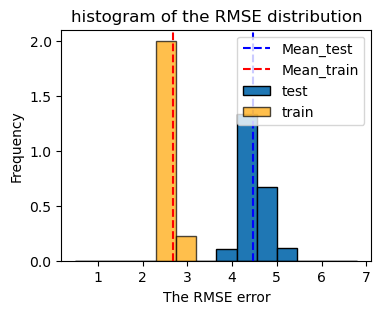

In [17]:
# RMSE in Total

print("RMSE in total", "\n")
rmse_bin_plot(test_RMSE["all"], train_RMSE["all"], test_AVE["all"], 0.5, 7.0, 0.45)

RMSE per bin 1

mean_RMSE_test: 0.26
stdev_RMSE_test: 0.06
mean_AVE_test: 0.07
stdev_AVE_test: 0.01


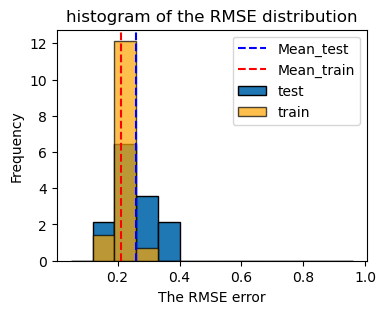

RMSE per bin 2

mean_RMSE_test: 2.19
stdev_RMSE_test: 0.25
mean_AVE_test: 0.93
stdev_AVE_test: 0.08


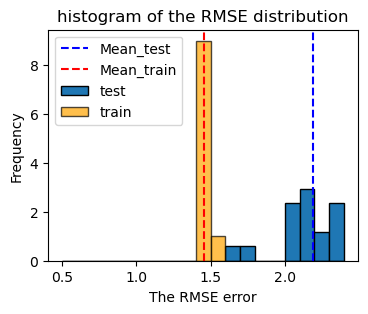

RMSE per bin 3

mean_RMSE_test: 4.71
stdev_RMSE_test: 0.55
mean_AVE_test: 1.04
stdev_AVE_test: 0.34


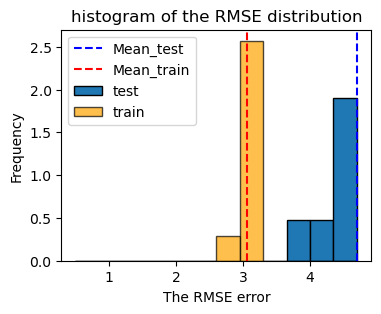

RMSE per bin 4

mean_RMSE_test: 13.24
stdev_RMSE_test: 1.11
mean_AVE_test: -6.09
stdev_AVE_test: 1.37


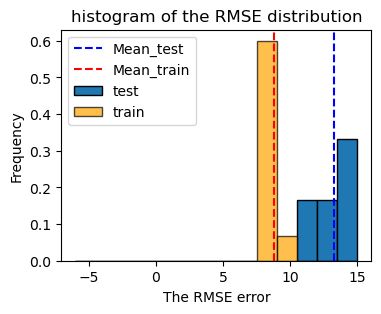

RMSE per bin 5

mean_RMSE_test: 27.99
stdev_RMSE_test: 4.07
mean_AVE_test: -20.24
stdev_AVE_test: 3.24


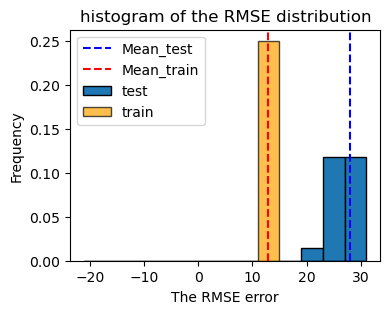

In [18]:
bin_params = {
    1: (0.05, 1.0, 0.07),
    2: (0.5, 2.5, 0.1),
    3: (0.5, 5, 0.35),
    4: (-6.0, 16.0, 1.5),
    5: (-21.0, 35.0, 4),
}


for bin_num in range(1, 6):

    print(f"RMSE per bin {bin_num}\n")
    rmse_bin_plot(
        test_RMSE[bin_num], train_RMSE[bin_num], test_AVE[bin_num], *bin_params[bin_num]
    )